In [8]:
import os
import nibabel as nib
from nibabel.testing import data_path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import tensorflow as tf
from tqdm import tqdm
import skimage.transform as skTrans

In [9]:
IMG_WIDTH=640
IMG_HEIGHT=640
IMG_CHANNELS=3

In [10]:
seed=40
np.random.seed=seed

# Try Outs

In [11]:
adc_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/ProstateMRI/10111/registered_adc_10111_nyul.nii"
adc=nib.load(adc_path).get_fdata()
adc.shape

(1024, 1024, 27)

In [12]:
hbv_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/ProstateMRI/10005/registered_hbv_10005_nyul.nii"
hbv=nib.load(hbv_path).get_fdata()
hbv.shape

(384, 384, 19)

In [13]:
t2w_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/ProstateMRI/10005/t2w_10005_nyul.nii"
t2w=nib.load(t2w_path).get_fdata()
t2w.shape

(384, 384, 19)

In [14]:
Prostate_Whole_Gland_Mask_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/Prostate_Whole_Gland_Mask/10005_1000005.nii"
Prostate_Whole_Gland_Mask=nib.load(Prostate_Whole_Gland_Mask_path).get_fdata()
#check if a slice contains mask(slice contains non-zero value)
print(Prostate_Whole_Gland_Mask.shape)
np.any(Prostate_Whole_Gland_Mask[:,:,10])

(384, 384, 19)


True

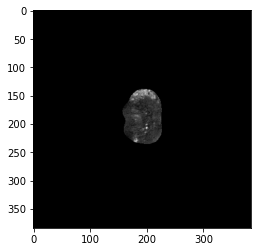

In [15]:
t2w_masked=t2w*Prostate_Whole_Gland_Mask
plt.imshow(t2w_masked[:,:,14],cmap='gray')

# Data Pre-processing

In [51]:
#This method will generate the Prostate Whole Gland Mask and Lesion Mask file_name for a given patient
def mask_file_format(patient_num):
    s=str()
    if(patient_num%10000<=129):
        s=str(patient_num)+"_"+str(patient_num%10000+1000000)
    if(patient_num%10000>=130 and patient_num%10000<=131):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+1)
    if(patient_num%10000>=132 and patient_num%10000<=153):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+2)
    if(patient_num%10000>=154 and patient_num%10000<=193):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+3)
    if(patient_num%10000>=194 and patient_num%10000<=273):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+4)
    if(patient_num%10000>=274 and patient_num%10000<=281):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+5)
    if(patient_num%10000>=282 and patient_num%10000<=404):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+6)
    if(patient_num%10000>=405 and patient_num%10000<=417):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+7)
    if(patient_num%10000>=418 and patient_num%10000<=490):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+8)
    if(patient_num%10000>=491 and patient_num%10000<=512):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+9)
    if(patient_num%10000>=513 and patient_num%10000<=540):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+10)
    if(patient_num%10000>=541 and patient_num%10000<=548):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+11)
    if(patient_num%10000>=549 and patient_num%10000<=576):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+12)
    if(patient_num%10000>=577 and patient_num%10000<=580):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+13)
    if(patient_num%10000>=581 and patient_num%10000<=629):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+14)
    if(patient_num%10000>=630 and patient_num%10000<=634):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+15)
    if(patient_num%10000>=635 and patient_num%10000<=905):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+16)
    if(patient_num%10000>=906 and patient_num%10000<=936):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+17)
    if(patient_num%10000>=937 and patient_num%10000<=1004):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+19)
    if(patient_num%10000>=1005 and patient_num%10000<=1054):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+20)
    if(patient_num%10000>=1055 and patient_num%10000<=1059):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+21)
    if(patient_num%10000>=1060 and patient_num%10000<=1087):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+22)
    if(patient_num%10000>=1088 and patient_num%10000<=1383):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+23)
    if(patient_num%10000>=1384 and patient_num%10000<=1475):
        s=str(patient_num)+"_"+str((patient_num%10000+1000000)+24)
    return s;

In [17]:
mask_file_format(11475)

'11475_1001499'

In [226]:
#This method will load co-registered ADC, co-registered HBV, T2W, and Prostate Whole Gland Mask of a given patient
def load_T2W_ADC_HBV_Whole_Gland_Mask(patient_num):
    loaded_image=list()
    #patient registered ADC path
    adc_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/ProstateMRI/"+str(patient_num)+r"/registered_adc_"+str(patient_num)+r"_nyul.nii"
    #patient registered HBV path
    hbv_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/ProstateMRI/"+str(patient_num)+r"/registered_hbv_"+str(patient_num)+r"_nyul.nii"
    #patient registered T2W path
    t2w_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/ProstateMRI/"+str(patient_num)+r"/t2w_"+str(patient_num)+r"_nyul.nii"
    #mask path
    mask_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/Prostate_Whole_Gland_Mask/"+mask_file_format(patient_num)+r".nii"
    
    #get T2W file
    t2w=nib.load(t2w_path).get_fdata()
    t2w = skTrans.resize(t2w, (640,640,t2w.shape[2]), order=1, preserve_range=True)
    loaded_image.append(t2w)
    
    #get registered ADC file
    adc=nib.load(adc_path).get_fdata()
    adc = skTrans.resize(adc, (640,640,adc.shape[2]), order=1, preserve_range=True)
    loaded_image.append(adc)
        
    #get registered HBV file
    hbv=nib.load(hbv_path).get_fdata()
    hbv = skTrans.resize(hbv, (640,640,hbv.shape[2]), order=1, preserve_range=True)
    loaded_image.append(hbv)
        
        
    #mask
    mask=nib.load(mask_path).get_fdata()
    mask = skTrans.resize(mask, (640,640,mask.shape[2]), order=1, preserve_range=True)
    loaded_image.append(mask)
    
    return loaded_image
    

In [118]:
#This method will check if a singke MRI image contains NaN value
#It will return True if given image doesn't contain NaN.
def NaN_checker(loaded_image):
    for i in range(loaded_image.shape[2]):
        if(True in np.isnan(loaded_image[:,:,i])):
            return False
    return True

In [126]:
NaN_checker(load_T2W_ADC_HBV_Whole_Gland_Mask(10342)[3])

True

In [112]:
#this method will mask the whole prostate gland on the given patients' ADC, HBV, T2W and output a list containing all the masked images
#-----------------------------------------------------------------------------------------------------------#
#In the returned prostate_whole_gland_masked_list, [0] is masked_T2W, [1] is masked_ADC, [2] is masked_HBV

def prostate_whole_gland_masked(loaded_image_list):
    prostate_whole_gland_masked_image_list=list()
        
    #prostate whole gland masked T2W
    masked_T2W=loaded_image_list[0]*loaded_image_list[3]
    prostate_whole_gland_masked_image_list.append(masked_T2W)
    #prostate whole gland masked ADC
    masked_ADC=loaded_image_list[1]*loaded_image_list[3]
    prostate_whole_gland_masked_image_list.append(masked_ADC)
    #prostate whole gland masked HBV
    masked_HBV=loaded_image_list[2]*loaded_image_list[3]
    prostate_whole_gland_masked_image_list.append(masked_HBV)

  
    return prostate_whole_gland_masked_image_list

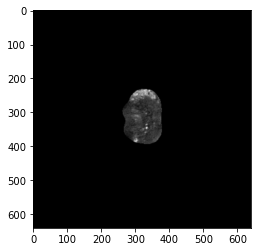

In [115]:
a=load_T2W_ADC_HBV_Whole_Gland_Mask(10005)
plt.imshow(prostate_whole_gland_masked(a)[0][:,:,14],cmap='gray')

In [21]:
#train dataset and test dataset
Human_Annotated_Patient_List=[10005,10012,10019,10021,10032,10040,10043,10048,10059,10074,10078,10079,10085,10097,
                              10103,10107,10110,10117,10118,10121,10134,10157,10164,10168,10202,10211,10216,10220,
                              10233,10234,10241,10252,10257,10262,10268,10274,10289,10294,10304,10322,10329,10338,
                              10339,10340,10342,10350,10355,10368,10372,10380,10383,10390,10392,10398,10405,10418,
                              10424,10434,10442,10451,10463,10473,10482,10484,10486,10503,10522,10523,10526,10529,
                              10539,10540,10549,10558,10568,10570,10589,10604,10605,10607,10620,10626,10635,10637,
                              10641,10665,10668,10670,10687,10688,10699,10700,10707,10721,10726,10728,10730,10743,
                              10768,10777,10798,10804,10807,10808,10825,10833,10834,10836,10839,10842,10867,10868,
                              10872,10880,10885,10888,10895,10901,10910,10911,10915,10920,10921,10925,10932,10938,
                              10942,10948,10953,10957,10961,10964,10968,10970,10975,10985,11002,11032,11039,11041,
                              11049,11050,11051,11054,11063,11068,11076,11080,11086,11100,11102,11114,11122,11130,
                              11137,11149,11152,11154,11155,11162,11163,11165,11168,11174,11177,11181,11185,11186,
                              11188,11190,11194,11198,11208,11225,11229,11231,11236,11247,11253,11256,11257,11260,
                              11269,11278,11280,11284,11299,11300,11305,11306,11330,11338,11345,11357,11361,11373,
                              11375,11377,11382,11384,11385,11397,11423,11428,11441,11442,11444,11446,11447,11448,
                              11450,11456,11462,11465,11471,11475]
len(Human_Annotated_Patient_List)
train_patient_list=[10005,10012,10019,10021,10032,10040,10043,10048,10059,10074,10078,10079,10085,10097,
                              10103,10107,10110,10117,10118,10121,10134,10157,10164,10168,10202,10211,10216,10220,
                              10233,10234,10241,10252,10257,10262,10268,10274,10289,10294,10304,10322,10329,10338,
                              10339,10340,10342,10350,10355,10482,10484,10486,10503,10522,10523,10526,10529,
                              10539,10549,10558,10568,10570,10589,10604,10605,10607,10620,10626,10635,10637,
                              10641,10665,10668,10670,10687,10688,10699,10700,10707,10721,10726,10728,10730,10743,
                              10768,10777,10798,10804,10807,10808,10825,10833,10834,10836,10839,10842,10867,10868,
                              10872,10880,10885,10888,10895,10901,10910,10911,10915,10920,10921,10925,10932,10938,
                              10942,10948,10953,10957,10961,10964,11163,11165,11168,11174,11177,11181,11185,11186,
                              11188,11190,11194,11198,11208,11225,11229,11231,11236,11247,11253,11256,11257,11260,
                              11269,11278,11280,11284,11299,11300,11305,11306,11330,11338,11345,11357,11361,11373,
                              11375,11377,11382,11385,11397,11423,11428,11441,11446,11447]
test_patient_list=[10368,10372,10380,10383,10390,10392,10398,10405,10418,
                              10424,10434,10442,10451,10463,10473,10968,10970,10975,10985,11002,11032,11039,11041,
                              11049,11050,11051,11054,11063,11068,11076,11080,11086,11100,11102,11114,11122,11130,
                              11137,11149,11152,11154,11155,11162,11442,11444,11448,
                              11450,11456,11462,11465,11471,11475]
len(test_patient_list)

52

In [22]:
#check for the patient who have more than 1 prostate MRI datasets
for i in Human_Annotated_Patient_List:
    if(i==10153):
        print(i)
    if(i==10193):
        print(i)
    if(i==10273):
        print(i)
    if(i==10281):
        print(i)
    if(i==10404):
        print(i)
    if(i==10417):
        print(i)
    if(i==10490):
        print(i)
    if(i==10512):
        print(i)
    if(i==10540):
        print(i)
    if(i==10548):
        print(i)
    if(i==10576):
        print(i)
    if(i==10580):
        print(i)
    if(i==10629):
        print(i)
    if(i==10634):
        print(i)
    if(i==10905):
        print(i)
    if(i==10936):
        print(i)
    if(i==11004):
        print(i)
    if(i==11055):
        print(i)
    if(i==11060):
        print(i)
    if(i==11088):
        print(i)
    if(i==11384):
        print(i)

10540
11384


In [23]:
#find the slice num which contains the lesion mask
def slices_containing_lesion_mask(lesion_mask):
    slices_containing_lesion_masks=list()
    for i in range(lesion_mask.shape[2]):
        if np.any(lesion_mask[:,:,i]):
            slices_containing_lesion_masks.append(i)
    return slices_containing_lesion_masks

In [24]:
#comebine certain slice of T2W, co-registered ADC, co-registered HBV together to make a 3 channel input for U-Net
#the parameters should be a !!slice!! of T2W, co-registered ADC, co-registered HBV, not the whole image
#make sure T2W, co-registered ADC, co-registered HBV slices have the same 2D dimension(column, row)

def combine_T2W_ADC_HBV_slice_into_3_channels(T2W_slice, ADC_slice, HBV_slice):
    combined_slice=np.zeros((T2W_slice.shape[0],T2W_slice.shape[1],3))
    combined_slice[:,:,0]=T2W_slice
    combined_slice[:,:,1]=ADC_slice
    combined_slice[:,:,2]=HBV_slice
    return combined_slice

In [102]:
#convert the lesion mask into 3 channels
def convert_lesion_mask_to_3_channels(lesion_mask_slice):
    converted_slice=np.zeros((lesion_mask_slice.shape[0],lesion_mask_slice.shape[1],1))
    converted_slice[:,:,0]=lesion_mask_slice
    return converted_slice

In [144]:
#initialize the train_prostate dataset and the train_mask_dataset
train_prostate=np.zeros((len(train_patient_list)*19,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.float64)
train_mask=np.zeros((len(train_patient_list)*19,IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool_)

#check if there is any NaN value in the initialized dataset
True in np.isnan(train_prostate)

False

In [145]:
def Train_Dataset_Generator(train_patient_list):
    index_tracker=0
    for i in tqdm(range(len(train_patient_list))):
        #load T2W, coregistered ADC, coregistered HBV and mask whole prostate gland on them
        loaded_image_list=load_T2W_ADC_HBV_Whole_Gland_Mask(train_patient_list[i])
        if(NaN_checker(loaded_image_list[0]) is False):
            print("Patient "+str(train_patient_list[i])+" T2W has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[1]) is False):
            print("Patient's "+str(train_patient_list[i])+" ADC has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[2]) is False):
            print("Patient's "+str(train_patient_list[i])+" HBV has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[3]) is False):
            print("Patient's "+str(train_patient_list[i])+" Whole Gland Mask has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[0]) and NaN_checker(loaded_image_list[1]) and NaN_checker(loaded_image_list[2]) and NaN_checker(loaded_image_list[3])):
            whole_gland_masked_image=prostate_whole_gland_masked(loaded_image_list)
            #load human-annotated lesion mask
            lesion_mask_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/human_annotated_masks/"+mask_file_format(train_patient_list[i])+r".nii"
            lesion_mask=nib.load(lesion_mask_path).get_fdata()
            #resize lesion_mask to 640*640
            lesion_mask = skTrans.resize(lesion_mask, (640,640,lesion_mask.shape[2]), order=1, preserve_range=True)
            if(NaN_checker(lesion_mask) is False):
                print("Patient's "+str(train_patient_list[i])+" Lesion Mask has NaN value. Thus this patient won't be added to dataset")
            else:
                #list of slices with lesion mask available
                slices_containing_lesion_masks=slices_containing_lesion_mask(lesion_mask)
                for j in slices_containing_lesion_masks:
                    #combined 3 channel T2W, ADC,HBV slices
                    combined_slice_T2W_ADC_HBV=combine_T2W_ADC_HBV_slice_into_3_channels(whole_gland_masked_image[0][:,:,j],whole_gland_masked_image[1][:,:,j],whole_gland_masked_image[2][:,:,j])
                    train_prostate[index_tracker]=combined_slice_T2W_ADC_HBV
                    train_mask[index_tracker]=convert_lesion_mask_to_3_channels(lesion_mask[:,:,j])
                    index_tracker=index_tracker+1
    return index_tracker 

(384, 384)

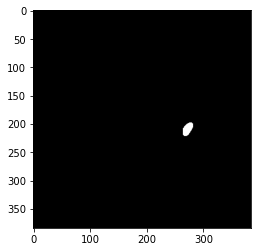

In [146]:
import skimage.transform as skTrans
lesion_mask_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/human_annotated_masks/"+mask_file_format(10012)+r".nii"
lesion_mask=nib.load(lesion_mask_path).get_fdata()
#lesion_mask = skTrans.resize(lesion_mask, (640,640,23), order=1, preserve_range=True)
plt.imshow(lesion_mask[:,:,7],cmap='gray')
lesion_mask[:,:,7].shape

In [147]:
x=Train_Dataset_Generator(train_patient_list)

  1%|▌                                          | 2/162 [00:09<12:30,  4.69s/it]

Patient's 10012 HBV has NaN value. Thus this patient won't be added to dataset


  7%|██▊                                       | 11/162 [00:55<13:08,  5.22s/it]

Patient's 10078 HBV has NaN value. Thus this patient won't be added to dataset


 14%|█████▋                                    | 22/162 [02:09<13:42,  5.88s/it]

Patient's 10157 HBV has NaN value. Thus this patient won't be added to dataset


 43%|█████████████████▉                        | 69/162 [07:07<07:42,  4.97s/it]

Patient's 10641 HBV has NaN value. Thus this patient won't be added to dataset


 91%|█████████████████████████████████████▏   | 147/162 [15:44<01:34,  6.31s/it]

Patient's 11330 HBV has NaN value. Thus this patient won't be added to dataset


100%|█████████████████████████████████████████| 162/162 [17:26<00:00,  6.46s/it]


In [148]:
x

905

In [149]:
#expect FALSE
True in np.isnan(train_prostate)

False

In [155]:
#expect FALSE
True in np.isnan(train_mask)

False

In [150]:
train_prostate_set=np.zeros((x,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.float64)
train_mask_set=np.zeros((x,IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool_)
for i in tqdm(range(x)):
    train_prostate_set[i]=train_prostate[i]
    train_mask_set[i]=train_mask[i]

100%|█████████████████████████████████████████| 905/905 [00:19<00:00, 47.43it/s]


(640, 640, 3)

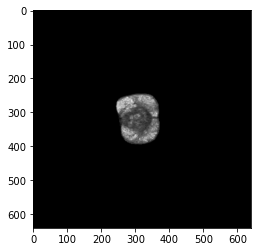

In [151]:
a=train_prostate_set[0]
plt.imshow(a[:,:,0],cmap='gray')
a.shape

In [153]:
#Expect FALSE
True in np.isnan(train_prostate_set)

False

In [156]:
#Expect FALSE
True in np.isnan(train_mask_set)

False

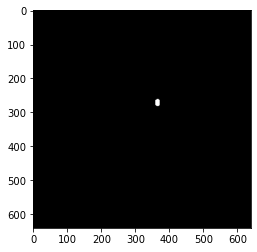

In [157]:
b=train_mask_set[0]
plt.imshow(b,cmap='gray')

# U-Net Architecture Construction

In [158]:
#input
inputs =tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS))
#encoder-stage 1
c1=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(inputs)
c1=tf.keras.layers.Dropout(0.1)(c1)
c1=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c1)
p1=tf.keras.layers.MaxPooling2D((2,2))(c1)
#encoder-stage 2
c2=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(p1)
c2=tf.keras.layers.Dropout(0.1)(c2)
c2=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)
#encoder-stage 3
c3=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(p2)
c3=tf.keras.layers.Dropout(0.2)(c3)
c3=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)
#encoder-stage 4
c4=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(p3)
c4=tf.keras.layers.Dropout(0.2)(c4)
c4=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)
#encoder-stage 5
c5=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c5)
#decoder-stage 6
u6=tf.keras.layers.Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(c5)
u6=tf.keras.layers.concatenate([u6,c4])
c6=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c6)
#decoder-stage 7
u7=tf.keras.layers.Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c7)
#decoder-stage 8
u8=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c7)
u8=tf.keras.layers.concatenate([u8,c2])
c8=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c8)
#decoder-stage 9
u9=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1],axis=3)
c9=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal', padding='same')(c9)
#output
outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)
model=tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 640, 640, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 640, 640, 64  0           ['conv2d_19[0][0]']              
                                )                                                           

                                6)                                                                
                                                                                                  
 conv2d_transpose_6 (Conv2DTran  (None, 320, 320, 12  131200     ['conv2d_32[0][0]']              
 spose)                         8)                                                                
                                                                                                  
 concatenate_6 (Concatenate)    (None, 320, 320, 25  0           ['conv2d_transpose_6[0][0]',     
                                6)                                'conv2d_22[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)             (None, 320, 320, 12  295040      ['concatenate_6[0][0]']          
                                8)                                                                
          

In [160]:
#add model checkpoint
checkpointer=tf.keras.callbacks.ModelCheckpoint('model_for_prostate_lesion_segmentation.h5', verbose=1, save_best_only=True)
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    checkpointer
]

In [161]:
train_prostate_set.shape

(905, 640, 640, 3)

In [162]:
train_mask_set.shape

(905, 640, 640, 1)

# U-Net Model Training

In [163]:
results=model.fit(train_prostate_set,train_mask_set,validation_split=0.2, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
46/46 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.9911  
Epoch 1: val_loss improved from inf to 0.01509, saving model to model_for_prostate_lesion_segmentation.h5
46/46 [==============================] - 9999s 218s/step - loss: 0.3717 - accuracy: 0.9911 - val_loss: 0.0151 - val_accuracy: 0.9965
Epoch 2/25
46/46 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9955  
Epoch 2: val_loss improved from 0.01509 to 0.01084, saving model to model_for_prostate_lesion_segmentation.h5
46/46 [==============================] - 8407s 183s/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0108 - val_accuracy: 0.9968
Epoch 3/25
46/46 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9959  
Epoch 3: val_loss did not improve from 0.01084
46/46 [==============================] - 8980s 196s/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.0110 - val_accuracy: 0.9968
Epoch 4/25
46/46 [==============================] 

In [164]:
#initialize test dataset
test_prostate=np.zeros((len(test_patient_list)*30,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.float64)
test_mask=np.zeros((len(test_patient_list)*30,IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool_)

In [166]:
def Test_Dataset_Generator(test_patient_list):
    index_tracker=0
    for i in tqdm(range(len(test_patient_list))):
        loaded_image_list=load_T2W_ADC_HBV_Whole_Gland_Mask(test_patient_list[i])
        if(NaN_checker(loaded_image_list[0]) is False):
            print("Patient "+str(train_patient_list[i])+" T2W has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[1]) is False):
            print("Patient's "+str(train_patient_list[i])+" ADC has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[2]) is False):
            print("Patient's "+str(train_patient_list[i])+" HBV has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[3]) is False):
            print("Patient's "+str(train_patient_list[i])+" Whole Gland Mask has NaN value. Thus this patient won't be added to dataset")
        if(NaN_checker(loaded_image_list[0]) and NaN_checker(loaded_image_list[1]) and NaN_checker(loaded_image_list[2]) and NaN_checker(loaded_image_list[3])):
            whole_gland_masked_image=prostate_whole_gland_masked(loaded_image_list)
            lesion_mask_path=r"/Users/wangkuancheng/Dropbox/Mac/Desktop/AI_Precision_Lab/Prostate_Image_Cancer_AI/human_annotated_masks/"+mask_file_format(test_patient_list[i])+r".nii"
            lesion_mask=nib.load(lesion_mask_path).get_fdata()
            lesion_mask = skTrans.resize(lesion_mask, (640,640,lesion_mask.shape[2]), order=1, preserve_range=True)
            if(NaN_checker(lesion_mask) is False):
                print("Patient's "+str(train_patient_list[i])+" Lesion Mask has NaN value. Thus this patient won't be added to dataset")
            else:
                for j in range(lesion_mask.shape[2]):
                    combined_slice_T2W_ADC_HBV=combine_T2W_ADC_HBV_slice_into_3_channels(whole_gland_masked_image[0][:,:,j],whole_gland_masked_image[1][:,:,j],whole_gland_masked_image[2][:,:,j])
                    test_prostate[index_tracker]=combined_slice_T2W_ADC_HBV
                    test_mask[index_tracker]=convert_lesion_mask_to_3_channels(lesion_mask[:,:,j])
                    index_tracker=index_tracker+1
            
    return index_tracker

In [167]:
y=Test_Dataset_Generator(test_patient_list)

 62%|██████████████████████████▍                | 32/52 [03:25<01:39,  4.96s/it]

Patient's 10252 HBV has NaN value. Thus this patient won't be added to dataset


 69%|█████████████████████████████▊             | 36/52 [03:54<01:35,  5.95s/it]

Patient's 10274 HBV has NaN value. Thus this patient won't be added to dataset


100%|███████████████████████████████████████████| 52/52 [05:47<00:00,  6.68s/it]


In [168]:
y

1184

In [169]:
#expect FALSE, which means there aren't any NaN value in the dataset
True in np.isnan(test_prostate)

False

In [170]:
#expect FALSE, which means there aren't any NaN value in the dataset
True in np.isnan(test_mask)

False

In [171]:
#reconstruct the test dataset for the prostate and mask
test_prostate_set=np.zeros((y,IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),dtype=np.float64)
test_mask_set=np.zeros((y,IMG_HEIGHT,IMG_WIDTH,1),dtype=np.float64)
for i in tqdm(range(y)):
    test_prostate_set[i]=test_prostate[i]
    test_mask_set[i]=test_mask[i]

100%|███████████████████████████████████████| 1184/1184 [00:21<00:00, 55.68it/s]


In [172]:
#expect FALSE, which means there aren't any NaN value in the dataset
True in np.isnan(test_prostate_set)

False

In [173]:
#expect FALSE, which means there aren't any NaN value in the dataset
True in np.isnan(test_mask_set)

False

In [174]:
#generated the U-Net predicted masks for the test_prostate_set
mask_predicted=model.predict(test_prostate_set)

37/37 [==============================] - 2559s 69s/step


In [203]:
len(mask_predicted)

1184

# Test My Model

### Result 1 (unbinary) : I find there are some correspondences between human-annotated mask and U-Net predicted mask in some cases

slice num:  369


(640, 640, 1)

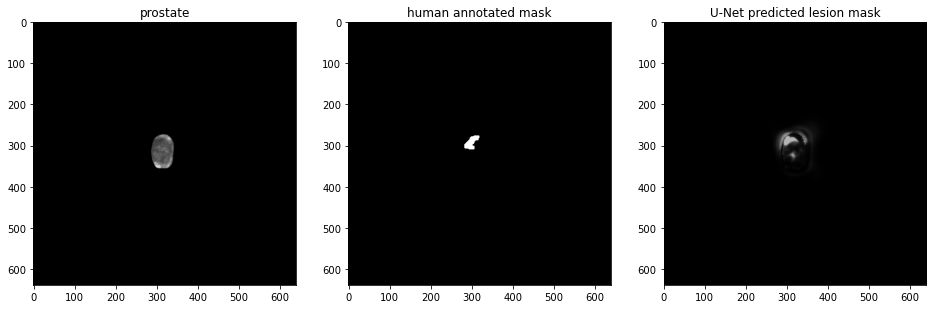

In [183]:
plt.figure(figsize=(16,16))
import random
slice_num=random.randint(0,len(mask_predicted)-1)
print("slice num: ", slice_num)

#test prostate
prostate=test_prostate_set[slice_num][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[slice_num]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[slice_num]
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask,cmap='gray')
predicted_mask.shape

slice num:  1061


(640, 640, 1)

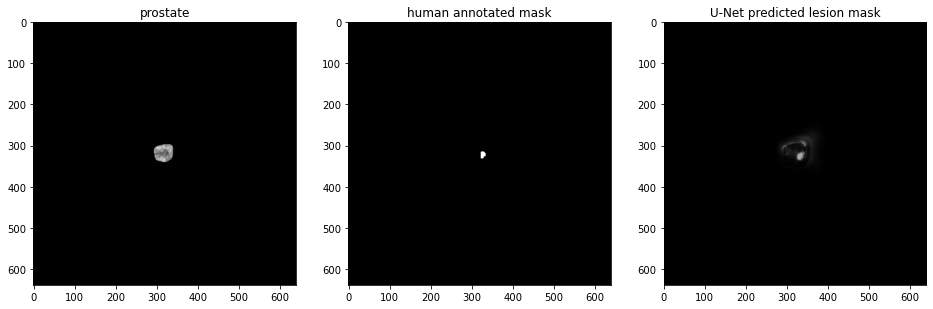

In [200]:
plt.figure(figsize=(16,16))
import random
slice_num=random.randint(0,len(mask_predicted)-1)
print("slice num: ", slice_num)

#test prostate
prostate=test_prostate_set[slice_num][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[slice_num]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[slice_num]
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask,cmap='gray')
predicted_mask.shape

slice num:  366


(640, 640, 1)

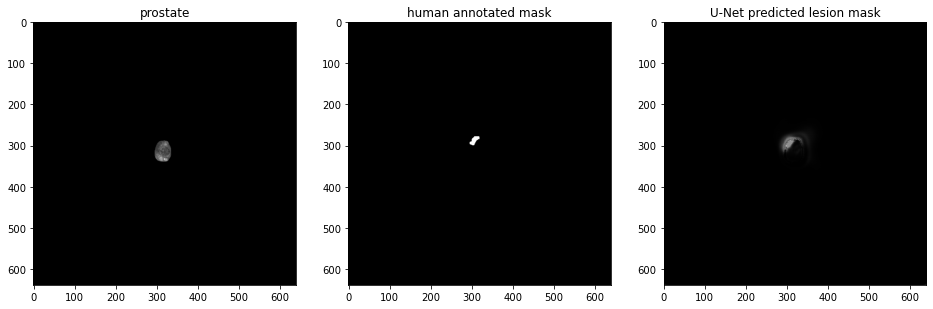

In [225]:
plt.figure(figsize=(16,16))
import random
slice_num=random.randint(0,len(mask_predicted)-1)
print("slice num: ", slice_num)

#test prostate
prostate=test_prostate_set[slice_num][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[slice_num]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[slice_num]
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask,cmap='gray')
predicted_mask.shape

### Result 2 (binary) : I try to binary the mask for case 434 in the test case

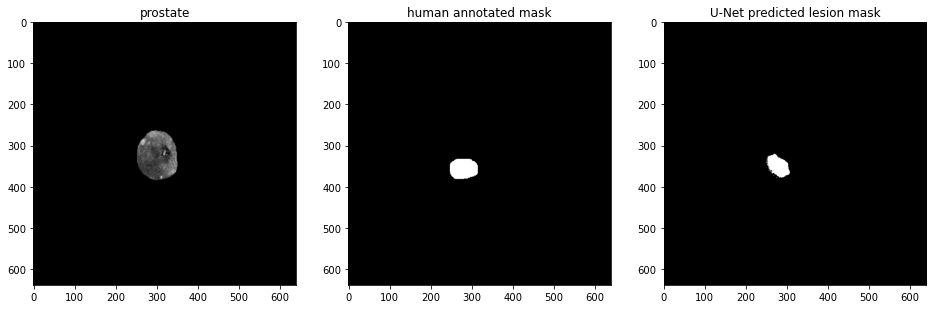

In [216]:
plt.figure(figsize=(16,16))

#test prostate
prostate=test_prostate_set[434][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[434]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[434]
predicted_mask_binary=(predicted_mask>0.4).astype(np.uint8)
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask_binary,cmap='gray')

### Result 3 (unbinary) : There is no correspondence between human-annotated mask and U-Net predicted mask  for some cases

slice num:  867


(640, 640, 1)

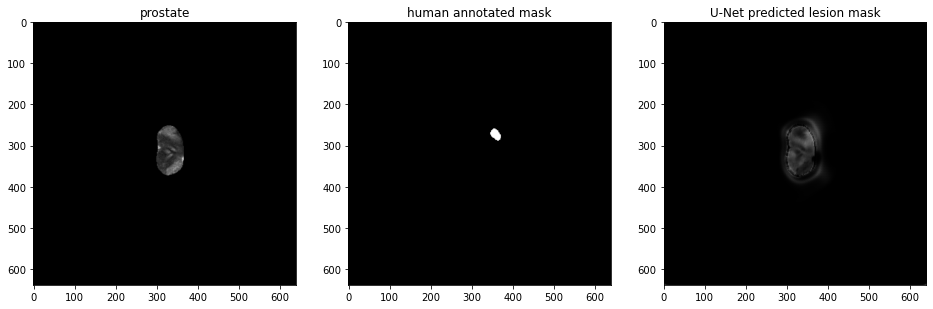

In [201]:
plt.figure(figsize=(16,16))
import random
slice_num=random.randint(0,len(mask_predicted)-1)
print("slice num: ", slice_num)

#test prostate
prostate=test_prostate_set[slice_num][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[slice_num]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[slice_num]
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask,cmap='gray')
predicted_mask.shape

### Result 4 (unbinary) : For certain slice, there is no lesion mask annotated by human, which means there shouldn't be any lesion in this case. However, U-Net Model still output something, which means my model has some problems

slice num:  170


(640, 640, 1)

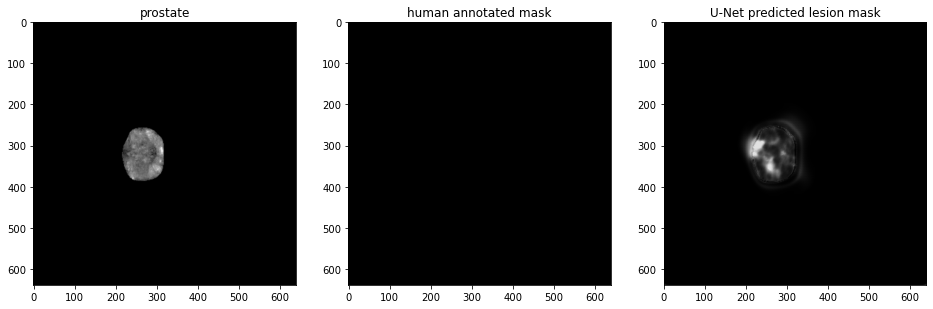

In [198]:
plt.figure(figsize=(16,16))
import random
slice_num=random.randint(0,len(mask_predicted)-1)
print("slice num: ", slice_num)

#test prostate
prostate=test_prostate_set[slice_num][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[slice_num]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[slice_num]
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask,cmap='gray')
predicted_mask.shape

### Result 3 (unbinary) : Prostate MRI T2W slice, human-annotated mask and U-Net predicted mask only contain 0s. This case is also strange to me since I don't think T2W should only contain 0s anytime.

slice num:  1048


(640, 640, 1)

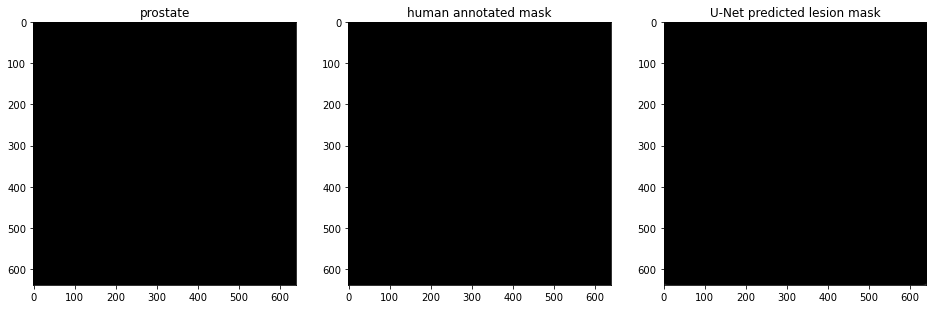

In [202]:
plt.figure(figsize=(16,16))
import random
slice_num=random.randint(0,len(mask_predicted)-1)
print("slice num: ", slice_num)

#test prostate
prostate=test_prostate_set[slice_num][:,:,0]
plt.subplot(231)
plt.title('prostate')
plt.imshow(prostate,cmap='gray')

#human annotated lesion_mask
human_annotated_mask=test_mask_set[slice_num]
plt.subplot(232)
plt.title('human annotated mask')
plt.imshow(human_annotated_mask,cmap='gray')

#U-Net predicted lesion mask
predicted_mask=mask_predicted[slice_num]
plt.subplot(233)
plt.title('U-Net predicted lesion mask')
plt.imshow(predicted_mask,cmap='gray')
predicted_mask.shape